In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filepath = '/content/drive/MyDrive/Colab Notebooks/BIBDA_2022/'

### install libraries

In [4]:
pip install wikirec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 1.9 MB/s 
     |████████████████████████████████| 176 kB 34.7 MB/s 
     |████████████████████████████████| 85 kB 5.9 MB/s 
     |████████████████████████████████| 316 kB 61.3 MB/s 
     |████████████████████████████████| 210 kB 60.9 MB/s 
     |████████████████████████████████| 5.5 MB 56.4 MB/s 
     |████████████████████████████████| 1.3 MB 63.5 MB/s 
     |████████████████████████████████| 163 kB 63.4 MB/s 
     |████████████████████████████████| 7.6 MB 50.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=88df3149321cde6e29ea8b9556d9bf9199de288ce7cb8627865c982eeed8a31d
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pluggy
    Found existing inst

In [5]:
import wikirec
import nltk
nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


True

### cleaning parsed articles

In [6]:
from wikirec import data_utils

# Downloads the most recent stable bz2 compressed English Wikipedia dump
files = data_utils.download_wiki(language="en", target_dir="./enwiki_dump")



Making ./enwiki_dump directory
DL file to ./enwiki_dump/enwiki-20221020-pages-articles-multistream1.xml-p1p41242.bz2
264577080/264577080 [==============================] - 50s 0us/step
DL file to ./enwiki_dump/enwiki-20221020-pages-articles-multistream2.xml-p41243p151573.bz2
354292943/354292943 [==============================] - 72s 0us/step
DL file to ./enwiki_dump/enwiki-20221020-pages-articles-multistream3.xml-p151574p311329.bz2
384215208/384215208 [==============================] - 80s 0us/step
DL file to ./enwiki_dump/enwiki-20221020-pages-articles-multistream4.xml-p311330p558391.bz2
428123882/428123882 [==============================] - 89s 0us/step
DL file to ./enwiki_dump/enwiki-20221020-pages-articles-multistream5.xml-p558392p958045.bz2
459879812/459879812 [==============================] - 96s 0us/step
DL file to ./enwiki_dump/enwiki-20221020-pages-articles-multistream6.xml-p958046p1483661.bz2
492330517/492330517 [==============================] - 101s 0us/step
DL file to ./e

KeyboardInterrupt: ignored

In [7]:
# Produces an ndjson of all book articles on Wikipedia
data_utils.parse_to_ndjson(
    topics="books",  # ["books", "short_stories", "plays"]
    output_path="./enwiki_books.ndjson",
    input_dir="./enwiki_dump",
    limit=1,  # articles per file to find
    multicore=True,
    verbose=True,
)

Making partitions directory for the partitions


Files partitioned:   0%|          | 0/16 [00:00<?, ?file/s]

File ./enwiki_books.ndjson with articles for the given topics saved


In [8]:
import json

with open("./enwiki_books.ndjson", "r") as f:
    books = [json.loads(l) for l in f]

titles = [b[0] for b in books]
texts = [b[1] for b in books]
wikilinks = [b[2] for b in books]  # internal wikipedia links for WikilinkNN method

text_corpus, selected_idxs = data_utils.clean(
    texts=texts,
    language="en",
    min_token_freq=5,  # 0 for Bert
    min_token_len=3,  # 0 for Bert
    min_tokens=50,
    max_token_index=-1,
    remove_stopwords=True,  # False for Bert
    verbose=True,
)

selected_titles = [titles[i] for i in selected_idxs]

Cleaning steps complete:   0%|          | 0/7 [00:00<?, ?step/s]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


n-grams generated:   0%|          | 0/16 [00:00<?, ?texts/s]

Unwanted words removed:   0%|          | 0/16 [00:00<?, ?texts/s]

Texts finalized:   0%|          | 0/4 [00:00<?, ?texts/s]

In [11]:
text_corpus

['books_category books_category books_category the story published written the book the book published story book the book literature author based life story book the book the books time the book the book category books category books category books category british books category british books category fiction books category books category english',
 'category_novels_set category_novels category_novels category_novels novels written the novels published the story novels novels story the the novels life the the life novels the time time time time time the story time written the the english the book novels published book the the english the book life the the english novels life the novels life fiction novels life novels novels novels novels novels novels british time time time literature time literature time literature time time literature time time literature literature literature time time literature life literature literature published title title set time author novels published tit



```
# This is formatted as code
```

### BERT

In [12]:
from wikirec import model

# Remove n-grams for BERT training
corpus_no_ngrams = [
    " ".join([t for t in text.split(" ") if "_" not in t]) for text in text_corpus
]

# We can pass kwargs for sentence_transformers.SentenceTransformer.encode
bert_embeddings = model.gen_embeddings(
        method="bert",
        corpus=corpus_no_ngrams,
        bert_st_model="xlm-r-bert-base-nli-stsb-mean-tokens",
        show_progress_bar=True,
        batch_size=32,
)

Downloading:   0%|          | 0.00/795 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/722 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
single_input_0 = "Moment in Peking"


In [23]:
selected_titles

['The Tiger Who Came to Tea',
 'Northanger Abbey',
 'The Autobiography of a Super-Tramp',
 'Moment in Peking']

In [26]:
def load_or_create_sim_matrix(
    method,
    corpus,
    metric,
    topic,
    path="./",
    bert_st_model="xlm-r-bert-base-nli-stsb-mean-tokens",
    **kwargs,
):
    """
    Loads or creats a similarity matrix to deliver recommendations
    
    NOTE: the .pkl files made are 5-10GB or more in size
    """
    if os.path.isfile(f"{path}{topic}_{metric}_{method}_sim_matrix.pkl"):
        print(f"Loading {method} {topic} {metric} similarity matrix.")
        with open(f"{path}{topic}_{metric}_{method}_sim_matrix.pkl", "rb") as f:
            sim_matrix = pickle.load(f)

    else:
        print(f"Creating {method} {topic} {metric} similarity matrix.")
        embeddings = model.gen_embeddings(
            method=method, corpus=corpus, bert_st_model=bert_st_model, **kwargs,
        )
        sim_matrix = model.gen_sim_matrix(
            method=method, metric=metric, embeddings=embeddings,
        )

        with open(f"{path}{topic}_{metric}_{method}_sim_matrix.pkl", "wb") as f:
            print(f"Pickling {method} {topic} {metric} similarity matrix.")
            pickle.dump(sim_matrix, f, protocol=4)

    return sim_matrix

In [ ]:
# Remove n-grams for BERT training
corpus_no_ngrams = [
    " ".join([t for t in text.split(" ") if "_" not in t]) for text in text_corpus
]

# We can pass kwargs for sentence_transformers.SentenceTransformer.encode
bert_sim_matrix = load_or_create_sim_matrix(
    method="bert",
    corpus=corpus_no_ngrams,
    metric="cosine",  # euclidean
    topic=topic,
    path="./",
    bert_st_model="xlm-r-bert-base-nli-stsb-mean-tokens",
    show_progress_bar=True,
    batch_size=32,
)


model.recommend(
    inputs=single_input_0,
    titles=selected_titles,
    sim_matrix=bert_sim_matrix,
    n=10,
    metric="cosine",
)

In [17]:
corpus_no_ngrams

['the story published written the book the book published story book the book literature author based life story book the book the books time the book the book category books category books category books category british books category british books category fiction books category books category english',
 'novels written the novels published the story novels novels story the the novels life the the life novels the time time time time time the story time written the the english the book novels published book the the english the book life the the english novels life the novels life fiction novels life novels novels novels novels novels novels british time time time literature time literature time literature time time literature time time literature literature literature time time literature life literature literature published title title set time author novels published title published novels published published british the british the fiction novels british book book book life the bo

###Doc2vec

In [20]:
from wikirec import model

# We can pass kwargs for gensim.models.doc2vec.Doc2Vec
d2v_embeddings = model.gen_embeddings(
        method="doc2vec",
        corpus=text_corpus,
        vector_size=100,
        epochs=10,
        alpha=0.025,
)

TypeError: ignored

###LDA

In [13]:
from wikirec import model

# We can pass kwargs for gensim.models.ldamulticore.LdaMulticore
lda_embeddings = model.gen_embeddings(
        method="lda",
        corpus=text_corpus,  # automatically tokenized for LDA
        num_topics=50,
        passes=10,
        decay=0.5,
)

###TFIDF

### Recommendations

In [19]:
from wikirec import model

sim_matrix = model.gen_sim_matrix(
    method="chosen_method",
    metric="cosine",  # euclidean
    embeddings=method_embeddings,
)

recs = model.recommend(
    inputs="title_or_list_of_titles",
    ratings=None,  # list of ints/floats between 0 and 10
    titles=selected_titles,
    sim_matrix=sim_matrix,
    metric="cosine",  # euclidean
    n=10,
)

NameError: ignored

In [ ]:
from gensim.models.phrases import Phrases
from nltk.corpus import stopwords
connectors = stopwords.words('english')

# bigram = Phrases(text, min_count=5, threshold=0.2, connector_words=connectors) #gensim 4
bigram = Phrases(text, min_count=5, threshold=0.2, common_terms=connectors) #gensim 3
bigrams = [bigram[item] for item in text]
print(bigrams[1])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['ok_nothing', 'special', 'charge', 'diamond_member', 'hilton', 'decided', 'chain', 'shot', '20th_anniversary', 'seattle', 'start', 'booked_suite', 'paid_extra', 'website', 'description', 'not', 'suite_bedroom', 'bathroom', 'standard_hotel', 'room_took', 'printed', 'reservation_desk', 'showed', 'said_thing', 'like', 'tv', 'couch', 'ect', 'desk_clerk', 'told', 'oh', 'mixed', 'suite', 'description', 'kimpton', 'website', 'sorry', 'free_breakfast', 'got', 'kidding', 'embassy', 'suit', 'sitting_room', 'bathroom_bedroom', 'unlike', 'kimpton', 'call', 'suite', 'day_stay', 'offer', 'correct', 'false_advertising', 'send', 'kimpton', 'preferred_guest', 'website', 'email', 'asking', 'failure', 'provide', 'suite', 'advertised_website', 'reservation', 'description', 'furnished', 'hard', 'copy', 'reservation', 'printout', 'website', 'desk_manager', 'duty', 'did', 'not', 'reply', 'solution', 'send_email', 'trip', 'guest', 'survey', 'did', 'not', 'follow', 'email', 'mail', 'guess', 'tell', 'concerned

Threshold parameter:
![image](https://drive.google.com/uc?id=1-_i5AtFU4dR1v1oYpH6nhzrjLjHbg9SX&authuser=lorenzo.malandri%40unimib.it&usp=drive_fs)

In [ ]:
# ngram = Phrases(bigrams, min_count=5, threshold=0.2, connector_words=connectors) # gensim 4
ngram = Phrases(bigrams, min_count=5, threshold=0.2, common_terms=connectors) # gensim 3
ngrams = [ngram[item] for item in bigrams]
print(ngrams[1])

['ok_nothing_special', 'charge', 'diamond_member', 'hilton', 'decided', 'chain', 'shot', '20th_anniversary', 'seattle', 'start', 'booked_suite', 'paid_extra', 'website', 'description', 'not', 'suite_bedroom', 'bathroom', 'standard_hotel', 'room_took', 'printed', 'reservation_desk', 'showed', 'said_thing', 'like', 'tv', 'couch', 'ect', 'desk_clerk', 'told', 'oh', 'mixed', 'suite', 'description', 'kimpton', 'website', 'sorry', 'free_breakfast', 'got', 'kidding', 'embassy', 'suit', 'sitting_room', 'bathroom_bedroom', 'unlike', 'kimpton', 'call', 'suite', 'day_stay', 'offer', 'correct', 'false_advertising', 'send', 'kimpton', 'preferred_guest', 'website', 'email', 'asking', 'failure', 'provide', 'suite', 'advertised_website', 'reservation', 'description', 'furnished', 'hard', 'copy', 'reservation', 'printout', 'website', 'desk_manager', 'duty', 'did', 'not', 'reply', 'solution', 'send_email', 'trip', 'guest', 'survey', 'did', 'not', 'follow', 'email', 'mail', 'guess', 'tell', 'concerned', 

### Remove Stopwords

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['good', 'bad', 'dont', 'many', 'love', 'excellent', 'would', 'perfect', 'even', 'great','nice', 'amazing'])
#print(ngrams[0])
train_sentences = []
for row in ngrams:
    train_sentences.append(' '.join([item for item in row if item not in stop]))
train_sentences[0]

# [1,2,3] [4,5,6]
# append[[1,2,3] [4,5,6]] 
# extend [1,2,3,4,5,6]

'nice_hotel expensive_parking got_good deal_stay hotel anniversary arrived_late evening took_advice previous_review valet_parking check_quick_easy little_disappointed non_existent view_room room_clean nice_size bed_comfortable woke stiff neck high pillow soundproof like heard music room_night morning loud bang door_opening closing hear_people_talking hallway maybe noisy neighbor aveda_bath product_nice goldfish stay_nice touch taken_advantage staying_longer location_great_walking_distance shopping overall_nice experience pay_40 parking night'

### save preprocessed data to file, tis going to be helpful later

In [ ]:
df_not_na['Review'] = train_sentences
df_not_na.to_csv(filepath+'data/tripadvisor_binary.csv', index=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### prepare BoW

**Bag** of Words:
![picture](https://drive.google.com/uc?id=1-kpVTNfdK4RFJ8e5ysaCNFAA1j8z1Ph9&authuser=lorenzo.malandri%40unimib.it&usp=drive_fs)



Term frequency - inverse document frequency:

![picture](https://drive.google.com/uc?id=1-VVNz4r6ML9naiRVRIPM-7HBE_0LDLPH&authuser=lorenzo.malandri%40unimib.it&usp=drive_fs)

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=1000)
# vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
X = vectorizer.fit_transform(train_sentences)
feature_names = vectorizer.get_feature_names()
X = X.toarray()
X = np.array(X)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### create train/test split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

### classify data

In [ ]:
from tqdm import tqdm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
model = RandomForestClassifier(n_estimators=10)
# model = tree.DecisionTreeClassifier()
# model = LogisticRegression(class_weight=None)
# model = RandomForestClassifier()

cvscores = []
cvrecall = []

for train, test in tqdm(kfold.split(x_train, y_train)):
    model.fit(x_train[train],y_train[train])
    predicted = model.predict(x_train[test])
    scores = accuracy_score(predicted, y_train[test])
    recall = recall_score(predicted, y_train[test])
    cvrecall.append(recall)
    cvscores.append(scores * 100)

print("accuracy: ",cvscores)
print("recall: ",cvrecall)

3it [00:03,  1.27s/it]

accuracy:  [83.8249063670412, 84.078670100679, 83.93818777803793]
recall:  [0.8870659010117583, 0.8825747374091032, 0.8848764594080912]


In [ ]:
from sklearn.metrics import classification_report

model.fit(x_train, y_train)
predicted = model.predict(x_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.57      0.43      0.49       964
           1       0.88      0.93      0.91      4529

    accuracy                           0.84      5493
   macro avg       0.73      0.68      0.70      5493
weighted avg       0.83      0.84      0.83      5493



### cross validated grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#cross_validated_grid_search for Random Forest
tree_model = tree.DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
               'max_depth': [None, 5, 10],
               'min_samples_split': [2, 10, 20]}

#cross_validated_grid_search for SVC
# model = svm.SVC()
# param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]

grid = GridSearchCV(estimator = tree_model, param_grid = param_grid, cv=3, verbose=2, n_jobs=-1, scoring='f1_weighted', refit=True)
# Fit the random search model
%time grid_result = grid.fit(x_train, y_train)

#print grid search results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
CPU times: user 2.47 s, sys: 461 ms, total: 2.93 s
Wall time: 1min 49s
Best: 0.835624 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
0.798483 (0.008416) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
0.803852 (0.005005) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10}
0.805344 (0.003691) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 20}
0.827501 (0.002503) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
0.827044 (0.002503) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}
0.827163 (0.002427) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 20}
0.833400 (0.001721) with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
0.832594 (0.001188) with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
0.832988 (0.001338) with: {'criterion': 'gini', 'max_depth':

In [ ]:
best_model = grid.best_estimator_
predicted = best_model.predict(x_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.60      0.37      0.46       964
           1       0.88      0.95      0.91      4529

    accuracy                           0.85      5493
   macro avg       0.74      0.66      0.68      5493
weighted avg       0.83      0.85      0.83      5493



### Display classification tree

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


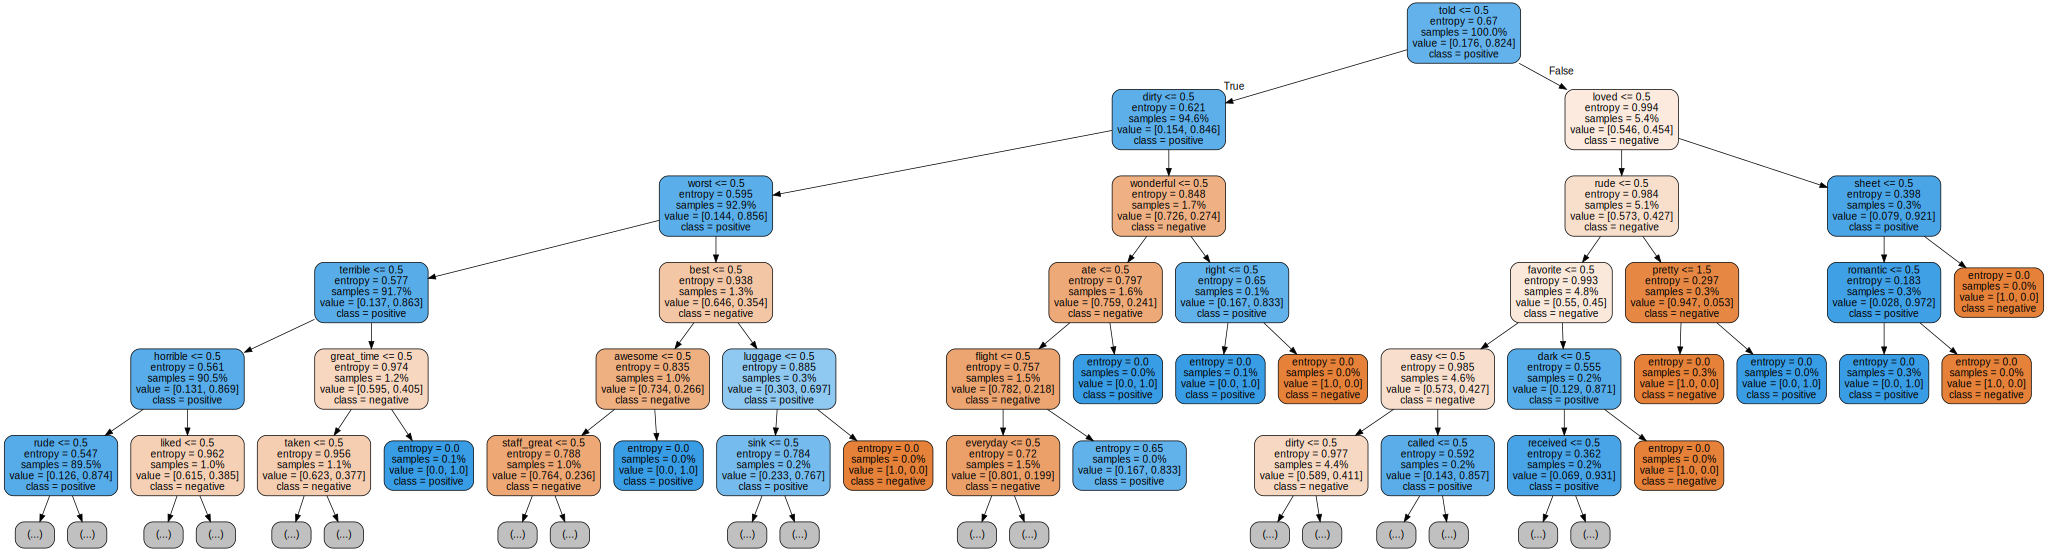

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot = export_graphviz(best_model,
                proportion=True,
                feature_names=feature_names,
                class_names=['negative', 'positive'],
                filled=True,
                rounded=True,
                max_depth=5)

graph = graphviz.Source(dot)
graph